# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第1节 择时策略的开发</b></font>
</center>

-----------------

作者: 阿布

阿布量化版权所有 未经允许 禁止转载

[abu量化系统github地址](https://github.com/bbfamily/abu) (欢迎+star)

[本节ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)

[本节界面操作教程视频播放地址](https://v.qq.com/x/page/g0555b9k6ge.html)


首先导入abupy中本节使用的模块：

In [1]:
# 基础库导入，注意第一次运行时会比较慢，要做数据的解压等处理操作
from __future__ import print_function
from __future__ import division

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

NumExpr defaulting to 8 threads.


In [2]:
abupy.env.enable_example_env_ipython()
abupy.env.g_data_fetch_mode = abupy.env.EMarketDataFetchMode.E_DATA_FETCH_FORCE_NET

enable example env will only read RomDataBu/csv


In [3]:
from abupy import ABuSymbolPd
ABuSymbolPd.make_kl_df('2330') is None

tw_TWSE:2330


False

In [4]:
us_jd = ABuSymbolPd.make_kl_df('2330')
us_jd.head()

tw_TWSE:2330


,open,close,high,low,volume,date,pre_close,date_week,p_change,atr21,atr14,key
2019-04-25,268.5,267.5,269.0,267.0,36572455,20190425,268.5,3,-0.372,2.0000,2.0000,0
2019-04-26,262.0,260.0,263.0,257.5,51743804,20190426,267.5,4,-2.804,6.7143,6.8214,1
2019-04-29,260.0,259.5,262.0,258.5,32651618,20190429,260.0,0,-0.192,7.5498,7.6537,2
2019-04-30,260.0,259.0,260.5,258.0,40446419,20190430,259.5,1,-0.193,6.1016,6.0770,3
2019-05-02,261.5,259.0,262.5,258.5,27376394,20190502,259.0,3,0.000,5.5976,5.5351,4


### 1. 买入择时因子的编写

海龟交易法则是量化经典书籍中的经典作品，它里面介绍过一种趋势跟踪策略：N日趋势突破策略

趋势突破定义为当天收盘价格超过N天内的最高价或最低价，超过最高价格作为买入信号买入股票持有，超过最低价格作为卖出信号。

下面将用abupy来实现海龟交易法则作为一个买入因子的实现代码，向经典致敬：

In [5]:
from abupy import AbuFactorBuyXD, BuyCallMixin

class AbuFactorBuyBreak(AbuFactorBuyXD, BuyCallMixin):
    """示例继承AbuFactorBuyXD完成正向突破买入择时类, 混入BuyCallMixin，即向上突破触发买入event"""
    def fit_day(self, today):
        """
        针对每一个交易日拟合买入交易策略，寻找向上突破买入机会
        :param today: 当前驱动的交易日金融时间序列数据
        :return:
        """

        # 今天的收盘价格达到xd天内最高价格则符合买入条件
        if today.close == self.xd_kl.close.max():
            # 生成买入订单, 由于使用了今天的收盘价格做为策略信号判断，所以信号发出后，只能明天买
            return self.buy_tomorrow()
        return None

上AbuFactorBuyBreak即是完成了海龟突破策略的代码实现：

1. 买入因子需要继承AbuFactorBuyXD或者更复杂的策略继承AbuFactorBuyBase
2. 买入因子混入BuyCallMixin，即做为正向策略，股票相关的策略全部是正向策略，即买涨，后续章节示例期货，期权会使用BuyPutMixin
3. 买入因子需要实现fit_day，即每一个交易日如何执行交易策略，当符合买入条件后，使用buy_tomorrow或者buy_today生成订单

更多买入因子实现代码请阅读AbuFactorBuyBase

### 2. 分解模式一步一步对策略进行回测

本节首先通过分解流程方式一步一步实现使用AbuFactorBuyBreak进行回测，目的是为了更清晰的说明内部操作流程，
编码过程会显的有些复杂臃肿，但实际上在编写完成一个策略后只需要使用一行代码即可以完成回测，在后面的小节中会进行讲解。

通过字典形式初始化买入buy_factors，首先实现针对一支股票的择时操作:

* benchmark的意义为基准参考，基准默认使用回测股票对应市场的大盘指数
* 默认参数下回测过去两年的交易数据，传递AbuBenchmark(n_folds=2)参数修改回测周期
* AbuCapital为资金主类，参数需要初始资金设定，这里初始设定1000000（100万），另一个参数为刚刚介绍过的benchmark（基准参考）对象
* buy_factors由两个买入因子组成，进行择时的时候两个因子同时并行生效

In [6]:
from abupy import AbuBenchmark
from abupy import AbuCapital

# buy_factors 60日向上突破，42日向上突破两个因子
buy_factors = [{'xd': 60, 'class': AbuFactorBuyBreak}, 
               {'xd': 42, 'class': AbuFactorBuyBreak}]
benchmark = AbuBenchmark()
capital = AbuCapital(100000000, benchmark)

tw_TWSE:2330


择时ABuPickTimeExecute主要驱动方式为时间驱动，即通过时间序列一天一天递进，通过买入因子卖出因子的fit来查询是否有事件生成（买入卖出行为），另外也有框架使用事件驱动，它们分别有各自的优点，原始的abu框架就是时间驱动＋事件驱动的，它最大的优点是执行效率比时间驱动高，但是灵活性及扩展性要比时间驱动差。

下面使用ABuPickTimeExecute开始进行择时交易回测，ABuPickTimeExecute实际上不是最简洁的回测接口，更简单的接口可以使用abu.run_loop_back()函数，在后面的章节将会示例使用，本节目的是为了更清晰的说明内部操作流程。

由回测结果图可看出由于AbuPickTimeWorker没有设置sell_factors，所以所有的交易单子都一直保留没有卖出：

* orders_pd：所有交易的相关数据（之后会有内容展示）
* action_pd：所有交易的行为数据（之后会有内容展示）

tw_TWSE:2330
             open  close   high    low    volume      date  pre_close  \
2019-04-25  268.5  267.5  269.0  267.0  36572455  20190425      268.5   
2019-04-26  262.0  260.0  263.0  257.5  51743804  20190426      267.5   
2019-04-29  260.0  259.5  262.0  258.5  32651618  20190429      260.0   
2019-04-30  260.0  259.0  260.5  258.0  40446419  20190430      259.5   
2019-05-02  261.5  259.0  262.5  258.5  27376394  20190502      259.0   
...           ...    ...    ...    ...       ...       ...        ...   
2021-04-19  605.0  603.0  607.0  601.0  25234976  20210419      610.0   
2021-04-20  598.0  602.0  602.0  595.0  36655069  20210420      603.0   
2021-04-21  599.0  592.0  599.0  592.0  41893725  20210421      602.0   
2021-04-22  596.0  591.0  598.0  591.0  38094824  20210422      592.0   
2021-04-23  592.0  602.0  602.0  590.0  29004756  20210423      591.0   

            date_week  p_change    atr21    atr14  key  
2019-04-25          3    -0.372   2.0000   2.0000    

Box(children=(Text(value='pid=3460 begin work'), FloatProgress(value=0.0)))

FloatProgress(value=0.0)

C:\Users\sean.chen\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\sean.chen\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\sean.chen\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\sean.chen\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook

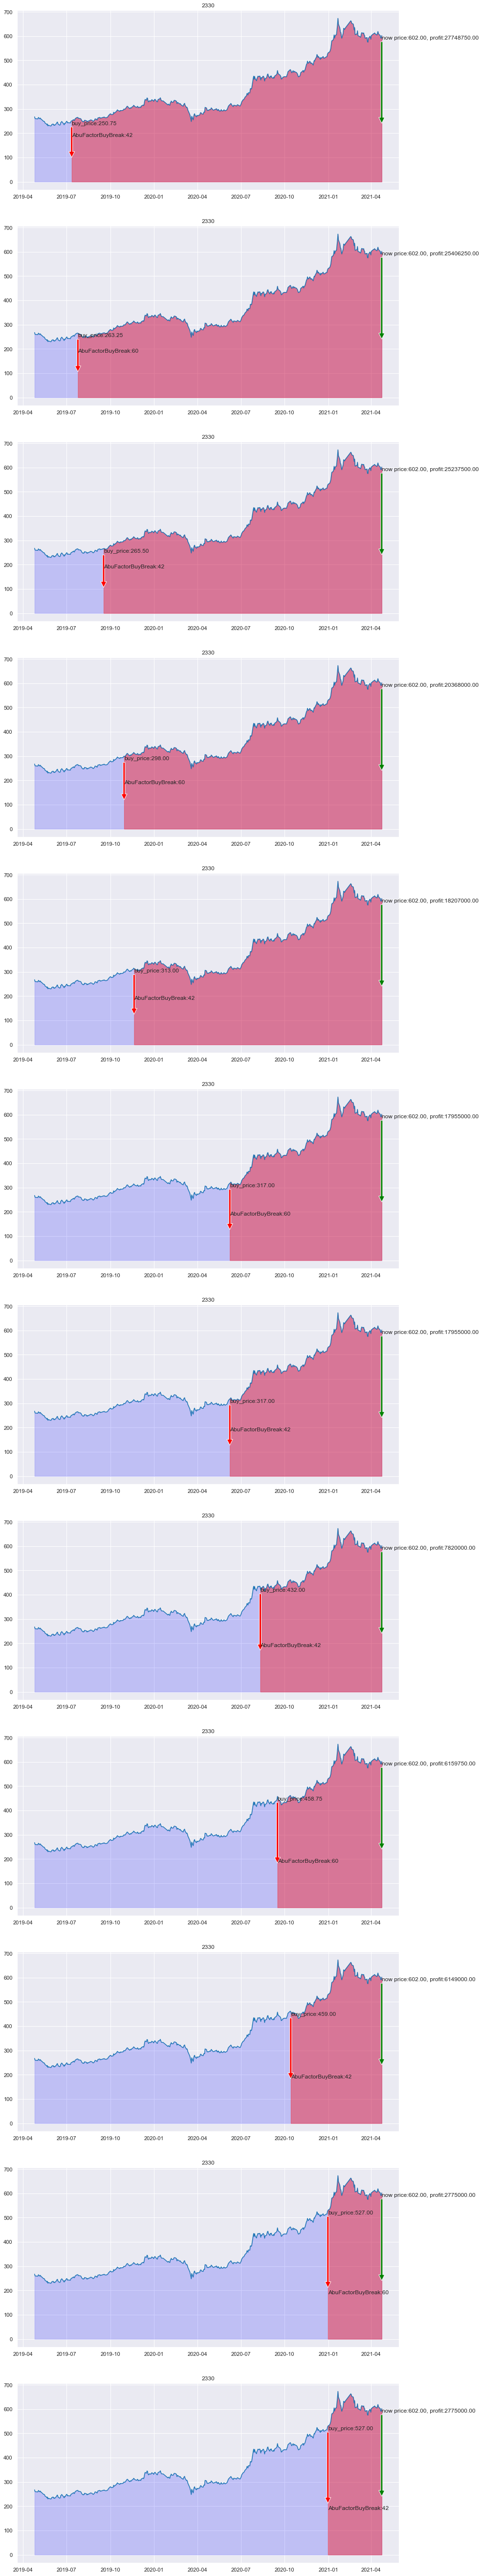

            buy_date  buy_price  buy_cnt            buy_factor symbol  \
2019-07-12  20190712     250.75  79000.0  AbuFactorBuyBreak:42   2330   
2019-07-25  20190725     263.25  75000.0  AbuFactorBuyBreak:60   2330   
2019-09-17  20190917     265.50  75000.0  AbuFactorBuyBreak:42   2330   
2019-10-30  20191030     298.00  67000.0  AbuFactorBuyBreak:60   2330   
2019-11-20  20191120     313.00  63000.0  AbuFactorBuyBreak:42   2330   
2020-06-08  20200608     317.00  63000.0  AbuFactorBuyBreak:60   2330   
2020-06-08  20200608     317.00  63000.0  AbuFactorBuyBreak:42   2330   
2020-08-11  20200811     432.00  46000.0  AbuFactorBuyBreak:42   2330   
2020-09-16  20200916     458.75  43000.0  AbuFactorBuyBreak:60   2330   
2020-10-14  20201014     459.00  43000.0  AbuFactorBuyBreak:42   2330   
2020-12-31  20201231     527.00  37000.0  AbuFactorBuyBreak:60   2330   
2020-12-31  20201231     527.00  37000.0  AbuFactorBuyBreak:42   2330   

                   buy_pos buy_type_str  expect_di

In [7]:
from abupy import ABuPickTimeExecute
orders_pd, action_pd, _ = ABuPickTimeExecute.do_symbols_with_same_factors(['2330'],
                                                                            benchmark,
                                                                            buy_factors,
                                                                            None,
                                                                            capital, show=True)
print (orders_pd)
print (action_pd)

### 3. 卖出择时因子的实现

上面所有单子都没有成交的原因是没有卖出因子，下面首先实现类似买入策略的N日趋势突破策略AbuFactorSellBreak，当股价向下突破N日最低价格时卖出股票，即当天收盘价格低于N天内最低价格作为卖出信号，认为下跌趋势成立卖出股票：

In [8]:
from abupy import AbuFactorSellXD, ESupportDirection

class AbuFactorSellBreak(AbuFactorSellXD):
    """示例继承AbuFactorBuyXD, 向下突破卖出择时因子"""
    def support_direction(self):
        """支持的方向，只支持正向"""
        return [ESupportDirection.DIRECTION_CAll.value]

    def fit_day(self, today, orders):
        """
        寻找向下突破作为策略卖出驱动event
        :param today: 当前驱动的交易日金融时间序列数据
        :param orders: 买入择时策略中生成的订单序列
        """
        # 今天的收盘价格达到xd天内最低价格则符合条件
        if today.close == self.xd_kl.close.min():
            for order in orders:
                self.sell_tomorrow(order)

C:\Users\sean.chen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel\ipkernel.py:281: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


上AbuFactorSellBreak即是完成了卖出突破策略的代码实现：

1. 卖出因子需要继承AbuFactorSellXD或者更复杂的策略继承AbuFactorSellBase
2. 卖出因子需要实现support_direction方法，确定策略支持的买入策略方向，本例中[ESupportDirection.DIRECTION_CAll.value]即只支持正向买入策略，即买涨
3. 卖出因子需要实现fit_day，看有没有符合卖出条件的交易单子

更多具体卖出因子实现代码请阅读AbuFactorSellBase

备注：之后章节的期货示例讲讲解如何使用ESupportDirection做反向交易，buy put

#### 3.2 买入因子和卖出因子在回测中同时生效

同理使用字典组装卖出因子：

In [9]:
# 使用120天向下突破为卖出信号
sell_factor1 = {'xd': 120, 'class': AbuFactorSellBreak}

# buy_factors 60日向上突破，42日向上突破两个因子
buy_factors = [{'xd': 60, 'class': AbuFactorBuyBreak}, 
               {'xd': 42, 'class': AbuFactorBuyBreak}]

# 只使用120天向下突破为卖出因子
sell_factors = [sell_factor1]
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, _ = ABuPickTimeExecute.do_symbols_with_same_factors(['2330'],
                                                                            benchmark,
                                                                            buy_factors,
                                                                            sell_factors,
                                                                            capital, show=True)

tw_TWSE:2330


D:\sean.chen\trader\abu\abupy\MarketBu\ABuSymbolPd.py:48: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  if len(df.index & benchmark.kl_pd.index) <= 0:


             open  close   high    low    volume      date  pre_close  \
2019-04-25  268.5  267.5  269.0  267.0  36572455  20190425      268.5   
2019-04-26  262.0  260.0  263.0  257.5  51743804  20190426      267.5   
2019-04-29  260.0  259.5  262.0  258.5  32651618  20190429      260.0   
2019-04-30  260.0  259.0  260.5  258.0  40446419  20190430      259.5   
2019-05-02  261.5  259.0  262.5  258.5  27376394  20190502      259.0   
...           ...    ...    ...    ...       ...       ...        ...   
2021-04-19  605.0  603.0  607.0  601.0  25234976  20210419      610.0   
2021-04-20  598.0  602.0  602.0  595.0  36655069  20210420      603.0   
2021-04-21  599.0  592.0  599.0  592.0  41893725  20210421      602.0   
2021-04-22  596.0  591.0  598.0  591.0  38094824  20210422      592.0   
2021-04-23  592.0  602.0  602.0  590.0  29004756  20210423      591.0   

            date_week  p_change    atr21    atr14  key  
2019-04-25          3    -0.372   2.0000   2.0000    0  
2019-04-2

Box(children=(Text(value='pid=3460 begin work'), FloatProgress(value=0.0)))

不夠最小單位量
不夠最小單位量
不夠最小單位量
不夠最小單位量
不夠最小單位量
不夠最小單位量
不夠最小單位量
不夠最小單位量
不夠最小單位量
不夠最小單位量
不夠最小單位量
不夠最小單位量


从上图可以看到，大多数的交易卖出因子都生效了，但效果很不好, 下一节将继续通过增加多个卖出因子同时作用于策略上来提高策略的效果。

#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)

[更多阿布量化量化技术文章](http://www.abuquant.com/article)

abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/tree/master/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/tree/master/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/tree/master/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/tree/master/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/tree/master/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/tree/master/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/tree/master/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/tree/master/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/tree/master/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/tree/master/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/tree/master/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/tree/master/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/tree/master/ipython/附录C-量化统计分析及指标应用.ipynb)

更多关于量化交易相关请阅读[《量化交易之路》](http://www.abuquant.com/books/quantify-trading-road.html)

更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://www.abuquant.com/books/machine-learning-road.html)

更多关于abu量化系统请关注微信公众号: abu_quant

![](./image/qrcode.jpg)